#  Análisis Exploratorio de Datos para volatilidad de cambio de monedas

**Integrantes**
- David López
- Camilo Velez
- Sebastian Ávila
- David Armendariz

## Librerías

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import STL

## Cargando Dataset

**Descripción**: Este dataset contiene la información histórica entre "2021-04-06" y "2024-04-06" con frecuencia diaria para las siguientes tasas de cambio:
- `Dolar EstadoUnidense` (USD) contra `Dolar Canadiende` (CAD)
- `Dolar EstadoUnidense` (USD) contra `Dolar Australiano` (CAD)

In [106]:
df=pd.read_excel("../data/raw/trm.xlsx")
print(df.shape)
print(df.dtypes)
df.head()

(785, 3)
Date                       datetime64[ns]
USDCAD BGN Curncy  (R1)           float64
USDAUD BGN Curncy  (L1)           float64
dtype: object


,Date,USDCAD BGN Curncy (R1),USDAUD BGN Curncy (L1)
0,2024-04-06,NaN,NaN
1,2024-04-05,1.3590,1.5201
2,2024-04-04,1.3543,1.5180
3,2024-04-03,1.3527,1.5233
4,2024-04-02,1.3567,1.5342


In [107]:
# Renombrando columnas

df.rename(columns={
    df.columns[0]: "Fecha",
    df.columns[1]: "USD_CAD",
    df.columns[2]: "USD_AUD",
    }, inplace=True)

df.head()

,Fecha,USD_CAD,USD_AUD
0,2024-04-06,NaN,NaN
1,2024-04-05,1.3590,1.5201
2,2024-04-04,1.3543,1.5180
3,2024-04-03,1.3527,1.5233
4,2024-04-02,1.3567,1.5342


## Explorando DataSet

### Visualización de comportamiento en el tiempo

In [108]:
# Plotting the data
fig = px.line(df, x='Fecha', y=['USD_CAD', 'USD_AUD'], title='USD-CAD and USD-AUD over time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Exchange Rate')
fig.show()

De acuerdo a la visualización anterior, se puede identificar una tendencia creciente en el largo plazo. Adicionalmente se destaca una alta volatilidad en ambas tasas de cambio.

### Análizando distribución de los datos en el tiempo.

In [109]:
# Extract year from the 'Fecha' column to use in grouping for the boxplot
df['Year'] = df['Fecha'].dt.year

# We will create a separate boxplot for each currency (USD_CAD and USD_AUD) per year.
# To do this, we need to reshape the DataFrame such that it contains 'Year', 'Value', and 'Variable' columns,
# where 'Variable' indicates the currency.
df_melted = df.melt(id_vars='Year', value_vars=['USD_CAD', 'USD_AUD'], var_name='Currency', value_name='Rate')

# Using Plotly Express to create the boxplot
fig = px.box(df_melted, x='Year', y='Rate', color='Currency', title='Exchange Rate Distribution per Year')

# Display the plot
fig.show()

De acuerdo al BoxPlot Anterior, se puede identificar que la varianza de los valores de cada tipo de cambio, es diferente cada año, por lo tanto, se puede concluir que no hay estacionalidad. 

Adicionalmente, para el año 2024, se pueden identificar algunos puntos por fuera de los boxplot (outliers), sin embargo, dado que estas variables tienen alta volatilidad es normal que esto suceda, por este motivo no se van a modificar.

### Analizando Missing Values

In [110]:
df=df.drop(columns="Year")
df.isna().value_counts()

Fecha  USD_CAD  USD_AUD
False  False    False      784
       True     True         1
Name: count, dtype: int64

Se puede identificar que hay una observación con datos faltantes para cada tipo de cambio. Por lo tanto, proceden a eliminarse

In [111]:
df=df.dropna()
print(df.shape)
df.head()

(784, 3)


,Fecha,USD_CAD,USD_AUD
1,2024-04-05,1.3590,1.5201
2,2024-04-04,1.3543,1.5180
3,2024-04-03,1.3527,1.5233
4,2024-04-02,1.3567,1.5342
5,2024-04-01,1.3570,1.5410


## Completando fechas faltantes

In [112]:
df.tail()

,Fecha,USD_CAD,USD_AUD
780,2021-04-12,1.2563,1.3117
781,2021-04-09,1.2530,1.3125
782,2021-04-08,1.2562,1.3066
783,2021-04-07,1.2609,1.3137
784,2021-04-06,1.2566,1.3049


Se pueden identificar huecos en las fechas, por ejemplo, observamos que pasamos del 9 de abril al 4 de abril. Esto se debe a que los fines de semana las tasas de cambio no tienen variaciones.

Sin embargo, vamos a completar estas fechas faltantes utilizando ***forward fill*** para que no se vean afectados los modelos.

In [113]:
df = df.sort_values('Fecha')

# Creating all missing dates between min and max date
all_dates = pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='D')

# Reindex the DataFrame with all dates
df = df.set_index('Fecha').reindex(all_dates).rename_axis('Fecha').reset_index()

# Filling NaN values with the value from the previous day (forward fill)
df.ffill(inplace=True)

print(df.shape)
print(df.dtypes)

df.head(8)

(1096, 3)
Fecha      datetime64[ns]
USD_CAD           float64
USD_AUD           float64
dtype: object


,Fecha,USD_CAD,USD_AUD
0,2021-04-06,1.2566,1.3049
1,2021-04-07,1.2609,1.3137
2,2021-04-08,1.2562,1.3066
3,2021-04-09,1.2530,1.3125
4,2021-04-10,1.2530,1.3125
5,2021-04-11,1.2530,1.3125
6,2021-04-12,1.2563,1.3117
7,2021-04-13,1.2535,1.3082


## Seasonal descompose

In [114]:
data = df.copy()
data.set_index('Fecha', inplace=True)
data_USD_CAD = data.drop("USD_AUD", axis=1)

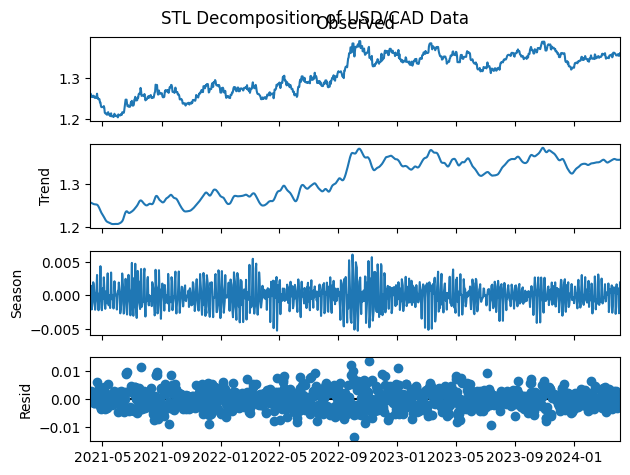

In [125]:
res_USD_CAD = STL(data_USD_CAD).fit()
res_USD_CAD.plot()  
plt.suptitle('STL Decomposition of USD/CAD Data')
plt.show()

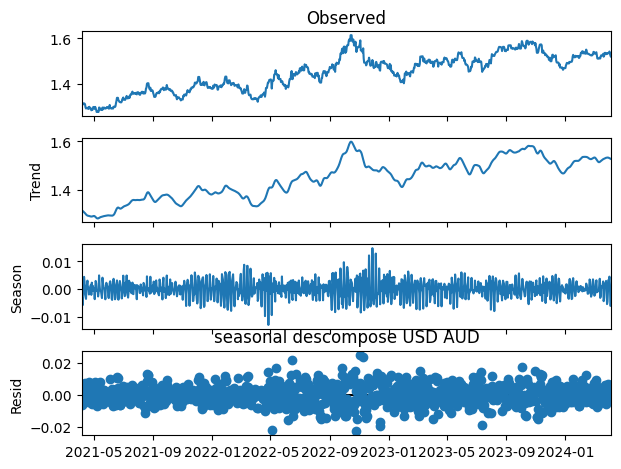

In [116]:
data = df.copy()
data.set_index('Fecha', inplace=True)
data_USD_AUD = data.drop("USD_CAD", axis=1)
res_USD_AUD = STL(data_USD_AUD).fit()
res_USD_AUD.plot()
plt.title("seasonal descompose USD AUD")
plt.show()

## Guardando DataFrame trusted

In [117]:
df.to_csv("../data/trusted/currency_exchange.csv",index=False)